https://www.kaggle.com/kazanova/sentiment140

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import nltk
from collections import Counter
import gensim
sns.set()

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
COLUMNS_NAMES = ['target','ids','date','flag','user','text']
W2V_DIMS_SIZE = 100
W2V_EPOCHS = 100
SEED=42
EMBEDDING_DIMS = 100
INPUT_MAX_LENGTH = 300
BATCH_SIZE=128
MODEL_EPOCHS = 5
VALIDATION_SPLIT = 0.1

In [3]:
df = pd.read_csv("dataset/data.csv",encoding='ISO-8859-1',names=COLUMNS_NAMES)

In [4]:
df

target         ids                          date      flag  \
0             0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1             0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2             0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3             0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4             0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1599995       4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996       4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997       4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998       4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999       4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  
0        _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1          scotthamilton  is upset that he can't update his Facebook by ...  
2               mattycus  @Kenichan I dived many times for the ball. Man...  
3                ElleCTF    my whole body feels itchy and like its on fire   
4                 Karoli  @nationwideclass no, it's not behaving at all....  
...                  ...                                                ...  
1599995  AmandaMarie1028  Just woke up. Having no school is the best fee...  
1599996      TheWDBoards  TheWDB.com - Very cool to hear old Walt interv...  
1599997           bpbabe  Are you ready for your MoJo Makeover? Ask me f...  
1599998     tinydiamondz  Happy 38th Birthday to my boo of alll time!!! ...  
1599999   RyanTrevMorris  happy #charitytuesday @theNSPCC @SparksCharity...  

[1600000 rows x 6 columns]

In [5]:
df['ids'].describe()

count    1.600000e+06
mean     1.998818e+09
std      1.935761e+08
min      1.467810e+09
25%      1.956916e+09
50%      2.002102e+09
75%      2.177059e+09
max      2.329206e+09
Name: ids, dtype: float64

In [6]:
df.drop(['ids'],axis=1,inplace=True)

In [7]:
df.flag.nunique(),df.flag.unique()

(1, array(['NO_QUERY'], dtype=object))

In [8]:
df.user.nunique(),df.user.unique()

(659775,
 array(['_TheSpecialOne_', 'scotthamilton', 'mattycus', ..., 'EvolveTom',
        'AmandaMarie1028', 'bpbabe'], dtype=object))

In [9]:
df.drop(['flag','user','date'],axis=1,inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [11]:
df.target.unique()

array([0, 4])

In [12]:
decode = {0:'Negative',2:'Neutral',4:"Positive"}
df.target = df.target.apply(lambda x:decode[x])

In [13]:
data_count = Counter(df['target'])

Text(0.5, 1.0, 'distribution')

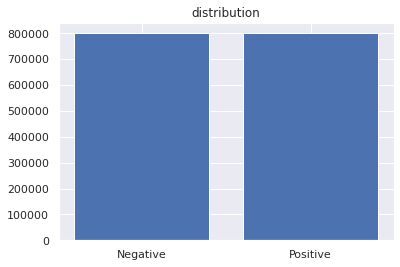

In [14]:
plt.bar(data_count.keys(),data_count.values())
plt.title("distribution")

In [15]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = stopwords.words('english')
stemmer = PorterStemmer()

In [16]:
import re
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def text_preprocessing(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            token = stemmer.stem(token)
            tokens.append(token)
    return " ".join(tokens)
df.text = df.text.apply(lambda x: text_preprocessing(x))

In [17]:
df

target                                               text
0        Negative       awww bummer shoulda got david carr third day
1        Negative  upset updat facebook text might cri result sch...
2        Negative    dive mani time ball manag save 50 rest go bound
3        Negative                    whole bodi feel itchi like fire
4        Negative                                      behav mad see
...           ...                                                ...
1599995  Positive                         woke school best feel ever
1599996  Positive            thewdb com cool hear old walt interview
1599997  Positive                       readi mojo makeov ask detail
1599998  Positive  happi 38th birthday boo alll time tupac amaru ...
1599999  Positive  happi charitytuesday thenspcc sparkschar speak...

[1600000 rows x 2 columns]

#### split dataset

In [18]:
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df,test_size=0.2)

In [19]:
df_train.shape,df_test.shape

((1280000, 2), (320000, 2))

In [20]:
documents = list(map(lambda x : nltk.word_tokenize(x),df_train.text))

In [21]:
from itertools import chain
all_words = list(chain.from_iterable(documents))   #flatten 2D list documents into 1D list
print(f'number of unique words: {len(set(all_words))}')
doc_counter = Counter(all_words)
word_features = dict(doc_counter.most_common(200000))
# print("most common : " , word_features )
word_features = word_features.keys()
features = []
for sent in documents:
    feature = []
    for word in sent:
        if word in word_features:
            feature.append(word)
    features.append(feature)

number of unique words: 248683


In [28]:
model = gensim.models.Word2Vec(
    min_count=1,
    window=4,
    size=W2V_DIMS_SIZE,
    seed=SEED,
)
model.build_vocab(features)
model.train(features, total_examples=len(features), epochs=W2V_EPOCHS)

INFO - 07:26:58: collecting all words and their counts
INFO - 07:26:58: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 07:26:58: PROGRESS: at sentence #10000, processed 73112 words, keeping 11524 word types
INFO - 07:26:58: PROGRESS: at sentence #20000, processed 146204 words, keeping 17633 word types
INFO - 07:26:58: PROGRESS: at sentence #30000, processed 219139 words, keeping 22582 word types
INFO - 07:26:58: PROGRESS: at sentence #40000, processed 291337 words, keeping 26849 word types
INFO - 07:26:58: PROGRESS: at sentence #50000, processed 363326 words, keeping 30608 word types
INFO - 07:26:58: PROGRESS: at sentence #60000, processed 435990 words, keeping 34339 word types
INFO - 07:26:58: PROGRESS: at sentence #70000, processed 508673 words, keeping 37752 word types
INFO - 07:26:58: PROGRESS: at sentence #80000, processed 581520 words, keeping 41041 word types
INFO - 07:26:58: PROGRESS: at sentence #90000, processed 653477 words, keeping 44250 word types

INFO - 07:26:59: PROGRESS: at sentence #830000, processed 6015509 words, keeping 186392 word types
INFO - 07:26:59: PROGRESS: at sentence #840000, processed 6088169 words, keeping 187932 word types
INFO - 07:26:59: PROGRESS: at sentence #850000, processed 6160718 words, keeping 189432 word types
INFO - 07:26:59: PROGRESS: at sentence #860000, processed 6233169 words, keeping 190917 word types
INFO - 07:26:59: PROGRESS: at sentence #870000, processed 6305702 words, keeping 192356 word types
INFO - 07:26:59: PROGRESS: at sentence #880000, processed 6378307 words, keeping 193771 word types
INFO - 07:26:59: PROGRESS: at sentence #890000, processed 6451030 words, keeping 195261 word types
INFO - 07:26:59: PROGRESS: at sentence #900000, processed 6522673 words, keeping 196646 word types
INFO - 07:26:59: PROGRESS: at sentence #910000, processed 6593358 words, keeping 196922 word types
INFO - 07:26:59: PROGRESS: at sentence #920000, processed 6665333 words, keeping 197121 word types
INFO - 07:

INFO - 07:27:49: EPOCH 4 - PROGRESS: at 95.10% examples, 1610966 words/s, in_qsize 6, out_qsize 0
INFO - 07:27:50: worker thread finished; awaiting finish of 2 more threads
INFO - 07:27:50: worker thread finished; awaiting finish of 1 more threads
INFO - 07:27:50: worker thread finished; awaiting finish of 0 more threads
INFO - 07:27:50: EPOCH - 4 : training on 9219937 raw words (8493088 effective words) took 5.3s, 1614465 effective words/s
INFO - 07:27:51: EPOCH 5 - PROGRESS: at 18.41% examples, 1573672 words/s, in_qsize 6, out_qsize 0
INFO - 07:27:52: EPOCH 5 - PROGRESS: at 36.66% examples, 1563518 words/s, in_qsize 6, out_qsize 0
INFO - 07:27:53: EPOCH 5 - PROGRESS: at 54.97% examples, 1562147 words/s, in_qsize 6, out_qsize 0
INFO - 07:27:54: EPOCH 5 - PROGRESS: at 74.10% examples, 1578567 words/s, in_qsize 6, out_qsize 0
INFO - 07:27:55: EPOCH 5 - PROGRESS: at 93.67% examples, 1589272 words/s, in_qsize 5, out_qsize 1
INFO - 07:27:55: worker thread finished; awaiting finish of 2 mor

INFO - 07:28:41: EPOCH 14 - PROGRESS: at 55.72% examples, 1584901 words/s, in_qsize 6, out_qsize 0
INFO - 07:28:42: EPOCH 14 - PROGRESS: at 75.09% examples, 1600085 words/s, in_qsize 6, out_qsize 0
INFO - 07:28:43: EPOCH 14 - PROGRESS: at 94.55% examples, 1604886 words/s, in_qsize 6, out_qsize 1
INFO - 07:28:43: worker thread finished; awaiting finish of 2 more threads
INFO - 07:28:43: worker thread finished; awaiting finish of 1 more threads
INFO - 07:28:43: worker thread finished; awaiting finish of 0 more threads
INFO - 07:28:43: EPOCH - 14 : training on 9219937 raw words (8493251 effective words) took 5.3s, 1609800 effective words/s
INFO - 07:28:44: EPOCH 15 - PROGRESS: at 18.63% examples, 1583242 words/s, in_qsize 6, out_qsize 0
INFO - 07:28:45: EPOCH 15 - PROGRESS: at 36.87% examples, 1568455 words/s, in_qsize 6, out_qsize 0
INFO - 07:28:46: EPOCH 15 - PROGRESS: at 53.67% examples, 1518410 words/s, in_qsize 5, out_qsize 0
INFO - 07:28:47: EPOCH 15 - PROGRESS: at 66.48% examples, 

INFO - 07:29:33: worker thread finished; awaiting finish of 0 more threads
INFO - 07:29:33: EPOCH - 23 : training on 9219937 raw words (8491978 effective words) took 5.2s, 1630989 effective words/s
INFO - 07:29:34: EPOCH 24 - PROGRESS: at 18.09% examples, 1543718 words/s, in_qsize 6, out_qsize 0
INFO - 07:29:35: EPOCH 24 - PROGRESS: at 37.20% examples, 1583988 words/s, in_qsize 6, out_qsize 0
INFO - 07:29:36: EPOCH 24 - PROGRESS: at 56.26% examples, 1595197 words/s, in_qsize 6, out_qsize 1
INFO - 07:29:37: EPOCH 24 - PROGRESS: at 75.42% examples, 1601967 words/s, in_qsize 6, out_qsize 0
INFO - 07:29:38: EPOCH 24 - PROGRESS: at 94.55% examples, 1600051 words/s, in_qsize 6, out_qsize 0
INFO - 07:29:38: worker thread finished; awaiting finish of 2 more threads
INFO - 07:29:38: worker thread finished; awaiting finish of 1 more threads
INFO - 07:29:38: worker thread finished; awaiting finish of 0 more threads
INFO - 07:29:38: EPOCH - 24 : training on 9219937 raw words (8492360 effective wor

INFO - 07:30:25: worker thread finished; awaiting finish of 2 more threads
INFO - 07:30:25: worker thread finished; awaiting finish of 1 more threads
INFO - 07:30:25: worker thread finished; awaiting finish of 0 more threads
INFO - 07:30:25: EPOCH - 33 : training on 9219937 raw words (8492850 effective words) took 5.3s, 1598495 effective words/s
INFO - 07:30:26: EPOCH 34 - PROGRESS: at 18.84% examples, 1609265 words/s, in_qsize 6, out_qsize 0
INFO - 07:30:27: EPOCH 34 - PROGRESS: at 37.20% examples, 1586520 words/s, in_qsize 6, out_qsize 0
INFO - 07:30:28: EPOCH 34 - PROGRESS: at 55.51% examples, 1578213 words/s, in_qsize 6, out_qsize 0
INFO - 07:30:29: EPOCH 34 - PROGRESS: at 73.88% examples, 1573851 words/s, in_qsize 5, out_qsize 0
INFO - 07:30:30: EPOCH 34 - PROGRESS: at 92.45% examples, 1569190 words/s, in_qsize 6, out_qsize 0
INFO - 07:30:31: worker thread finished; awaiting finish of 2 more threads
INFO - 07:30:31: worker thread finished; awaiting finish of 1 more threads
INFO - 

INFO - 07:31:18: EPOCH 43 - PROGRESS: at 75.64% examples, 1607301 words/s, in_qsize 6, out_qsize 0
INFO - 07:31:19: EPOCH 43 - PROGRESS: at 95.10% examples, 1608812 words/s, in_qsize 5, out_qsize 0
INFO - 07:31:19: worker thread finished; awaiting finish of 2 more threads
INFO - 07:31:19: worker thread finished; awaiting finish of 1 more threads
INFO - 07:31:19: worker thread finished; awaiting finish of 0 more threads
INFO - 07:31:19: EPOCH - 43 : training on 9219937 raw words (8493644 effective words) took 5.3s, 1612501 effective words/s
INFO - 07:31:20: EPOCH 44 - PROGRESS: at 19.27% examples, 1648623 words/s, in_qsize 5, out_qsize 0
INFO - 07:31:21: EPOCH 44 - PROGRESS: at 38.37% examples, 1635003 words/s, in_qsize 6, out_qsize 0
INFO - 07:31:22: EPOCH 44 - PROGRESS: at 56.80% examples, 1612284 words/s, in_qsize 6, out_qsize 0
INFO - 07:31:23: EPOCH 44 - PROGRESS: at 74.98% examples, 1592744 words/s, in_qsize 5, out_qsize 0
INFO - 07:31:24: EPOCH 44 - PROGRESS: at 93.12% examples, 

INFO - 07:32:08: EPOCH 53 - PROGRESS: at 37.94% examples, 1616022 words/s, in_qsize 6, out_qsize 0
INFO - 07:32:09: EPOCH 53 - PROGRESS: at 57.34% examples, 1628369 words/s, in_qsize 6, out_qsize 0
INFO - 07:32:10: EPOCH 53 - PROGRESS: at 76.96% examples, 1637235 words/s, in_qsize 6, out_qsize 0
INFO - 07:32:11: EPOCH 53 - PROGRESS: at 96.65% examples, 1638641 words/s, in_qsize 6, out_qsize 0
INFO - 07:32:11: worker thread finished; awaiting finish of 2 more threads
INFO - 07:32:11: worker thread finished; awaiting finish of 1 more threads
INFO - 07:32:11: worker thread finished; awaiting finish of 0 more threads
INFO - 07:32:11: EPOCH - 53 : training on 9219937 raw words (8493194 effective words) took 5.2s, 1640572 effective words/s
INFO - 07:32:12: EPOCH 54 - PROGRESS: at 19.27% examples, 1641984 words/s, in_qsize 6, out_qsize 0
INFO - 07:32:13: EPOCH 54 - PROGRESS: at 38.70% examples, 1644872 words/s, in_qsize 6, out_qsize 0
INFO - 07:32:14: EPOCH 54 - PROGRESS: at 57.77% examples, 

INFO - 07:32:59: EPOCH - 62 : training on 9219937 raw words (8492742 effective words) took 5.3s, 1591742 effective words/s
INFO - 07:33:00: EPOCH 63 - PROGRESS: at 18.20% examples, 1553743 words/s, in_qsize 6, out_qsize 0
INFO - 07:33:01: EPOCH 63 - PROGRESS: at 36.66% examples, 1563099 words/s, in_qsize 6, out_qsize 0
INFO - 07:33:02: EPOCH 63 - PROGRESS: at 54.76% examples, 1554406 words/s, in_qsize 6, out_qsize 2
INFO - 07:33:03: EPOCH 63 - PROGRESS: at 73.34% examples, 1560710 words/s, in_qsize 6, out_qsize 0
INFO - 07:33:04: EPOCH 63 - PROGRESS: at 92.13% examples, 1562536 words/s, in_qsize 6, out_qsize 0
INFO - 07:33:05: worker thread finished; awaiting finish of 2 more threads
INFO - 07:33:05: worker thread finished; awaiting finish of 1 more threads
INFO - 07:33:05: worker thread finished; awaiting finish of 0 more threads
INFO - 07:33:05: EPOCH - 63 : training on 9219937 raw words (8492484 effective words) took 5.4s, 1565543 effective words/s
INFO - 07:33:06: EPOCH 64 - PROGRE

INFO - 07:33:52: worker thread finished; awaiting finish of 2 more threads
INFO - 07:33:52: worker thread finished; awaiting finish of 1 more threads
INFO - 07:33:52: worker thread finished; awaiting finish of 0 more threads
INFO - 07:33:52: EPOCH - 72 : training on 9219937 raw words (8491884 effective words) took 5.4s, 1568114 effective words/s
INFO - 07:33:53: EPOCH 73 - PROGRESS: at 18.52% examples, 1570097 words/s, in_qsize 6, out_qsize 1
INFO - 07:33:54: EPOCH 73 - PROGRESS: at 37.20% examples, 1574439 words/s, in_qsize 6, out_qsize 1
INFO - 07:33:55: EPOCH 73 - PROGRESS: at 55.72% examples, 1577344 words/s, in_qsize 5, out_qsize 0
INFO - 07:33:56: EPOCH 73 - PROGRESS: at 74.21% examples, 1576302 words/s, in_qsize 6, out_qsize 0
INFO - 07:33:57: EPOCH 73 - PROGRESS: at 93.78% examples, 1587434 words/s, in_qsize 6, out_qsize 0
INFO - 07:33:58: worker thread finished; awaiting finish of 2 more threads
INFO - 07:33:58: worker thread finished; awaiting finish of 1 more threads
INFO - 

INFO - 07:34:44: EPOCH 82 - PROGRESS: at 73.77% examples, 1570154 words/s, in_qsize 5, out_qsize 0
INFO - 07:34:45: EPOCH 82 - PROGRESS: at 92.45% examples, 1568023 words/s, in_qsize 6, out_qsize 0
INFO - 07:34:45: worker thread finished; awaiting finish of 2 more threads
INFO - 07:34:45: worker thread finished; awaiting finish of 1 more threads
INFO - 07:34:45: worker thread finished; awaiting finish of 0 more threads
INFO - 07:34:45: EPOCH - 82 : training on 9219937 raw words (8492147 effective words) took 5.4s, 1568935 effective words/s
INFO - 07:34:46: EPOCH 83 - PROGRESS: at 18.94% examples, 1618069 words/s, in_qsize 5, out_qsize 0
INFO - 07:34:47: EPOCH 83 - PROGRESS: at 38.27% examples, 1632950 words/s, in_qsize 6, out_qsize 0
INFO - 07:34:48: EPOCH 83 - PROGRESS: at 57.66% examples, 1638483 words/s, in_qsize 6, out_qsize 0
INFO - 07:34:49: EPOCH 83 - PROGRESS: at 77.07% examples, 1640066 words/s, in_qsize 6, out_qsize 0
INFO - 07:34:50: EPOCH 83 - PROGRESS: at 96.77% examples, 

INFO - 07:35:35: EPOCH 92 - PROGRESS: at 37.41% examples, 1591367 words/s, in_qsize 6, out_qsize 0
INFO - 07:35:36: EPOCH 92 - PROGRESS: at 56.26% examples, 1596125 words/s, in_qsize 6, out_qsize 0
INFO - 07:35:37: EPOCH 92 - PROGRESS: at 75.20% examples, 1598274 words/s, in_qsize 6, out_qsize 0
INFO - 07:35:38: EPOCH 92 - PROGRESS: at 94.10% examples, 1594508 words/s, in_qsize 6, out_qsize 0
INFO - 07:35:38: worker thread finished; awaiting finish of 2 more threads
INFO - 07:35:38: worker thread finished; awaiting finish of 1 more threads
INFO - 07:35:38: worker thread finished; awaiting finish of 0 more threads
INFO - 07:35:38: EPOCH - 92 : training on 9219937 raw words (8492658 effective words) took 5.3s, 1597587 effective words/s
INFO - 07:35:39: EPOCH 93 - PROGRESS: at 18.73% examples, 1600921 words/s, in_qsize 5, out_qsize 0
INFO - 07:35:40: EPOCH 93 - PROGRESS: at 37.52% examples, 1597396 words/s, in_qsize 5, out_qsize 0
INFO - 07:35:41: EPOCH 93 - PROGRESS: at 55.61% examples, 

(849290431, 921993700)

In [ ]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling
import matplotlib.pyplot as plt
import random

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_with_matplotlib(x_vals, y_vals, labels,samples=25):
    random.seed(0)

    plt.figure(figsize=(12, 12))
    

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, samples)
    for i in selected_indices:
        plt.scatter(x_vals[i], y_vals[i])
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))


        
# x_vals, y_vals, labels = reduce_dimensions(model)
# plot_with_matplotlib(x_vals, y_vals, labels,samples=10)

### Save and load the model

In [22]:
filepath = "saved_models/gensim-model-w2v"
# model.save(filepath)
w2v = gensim.models.Word2Vec.load(filepath)

INFO - 08:18:23: loading Word2Vec object from saved_models/gensim-model-w2v
INFO - 08:18:23: loading wv recursively from saved_models/gensim-model-w2v.wv.* with mmap=None
INFO - 08:18:23: loading vectors from saved_models/gensim-model-w2v.wv.vectors.npy with mmap=None
INFO - 08:18:23: setting ignored attribute vectors_norm to None
INFO - 08:18:23: loading vocabulary recursively from saved_models/gensim-model-w2v.vocabulary.* with mmap=None
INFO - 08:18:23: loading trainables recursively from saved_models/gensim-model-w2v.trainables.* with mmap=None
INFO - 08:18:23: loading syn1neg from saved_models/gensim-model-w2v.trainables.syn1neg.npy with mmap=None
INFO - 08:18:23: setting ignored attribute cum_table to None
INFO - 08:18:23: loaded saved_models/gensim-model-w2v


In [23]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_train.text)
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 248688


In [24]:
for word,index in tokenizer.word_index.items():
    print("{} --> {}".format(index,word))

1 --> go
2 --> get
3 --> day
4 --> good
5 --> work
6 --> like
7 --> love
8 --> quot
9 --> today
10 --> time
11 --> got
12 --> thank
13 --> lol
14 --> want
15 --> back
16 --> miss
17 --> one
18 --> u
19 --> know
20 --> see
21 --> feel
22 --> think
23 --> im
24 --> realli
25 --> amp
26 --> night
27 --> hope
28 --> watch
29 --> need
30 --> still
31 --> make
32 --> 2
33 --> well
34 --> new
35 --> home
36 --> oh
37 --> look
38 --> come
39 --> much
40 --> twitter
41 --> last
42 --> morn
43 --> tomorrow
44 --> wish
45 --> great
46 --> 3
47 --> sleep
48 --> wait
49 --> haha
50 --> sad
51 --> fun
52 --> week
53 --> tri
54 --> follow
55 --> right
56 --> happi
57 --> bad
58 --> would
59 --> thing
60 --> sorri
61 --> tonight
62 --> friend
63 --> say
64 --> way
65 --> take
66 --> nice
67 --> though
68 --> gonna
69 --> better
70 --> hate
71 --> even
72 --> bed
73 --> yeah
74 --> tweet
75 --> could
76 --> start
77 --> school
78 --> peopl
79 --> hour
80 --> show
81 --> weekend
82 --> guy
83 --> play
8

4814 --> fucker
4815 --> dw
4816 --> pencil
4817 --> dreamt
4818 --> stamp
4819 --> mimi
4820 --> tale
4821 --> buse
4822 --> belgium
4823 --> corpor
4824 --> malaysia
4825 --> rail
4826 --> syrup
4827 --> poni
4828 --> ralli
4829 --> tether
4830 --> slower
4831 --> ick
4832 --> moan
4833 --> imax
4834 --> fork
4835 --> weigh
4836 --> compet
4837 --> grandfath
4838 --> 24th
4839 --> pg
4840 --> grader
4841 --> breast
4842 --> brittani
4843 --> andyhurleyday
4844 --> sarcasm
4845 --> ahahah
4846 --> kickin
4847 --> tk
4848 --> nada
4849 --> valid
4850 --> kayla
4851 --> ther
4852 --> databas
4853 --> alik
4854 --> platform
4855 --> pacif
4856 --> dec
4857 --> fishi
4858 --> wp
4859 --> bookmark
4860 --> becca
4861 --> captur
4862 --> nudg
4863 --> zomg
4864 --> knife
4865 --> badg
4866 --> mash
4867 --> freezer
4868 --> tonsil
4869 --> trim
4870 --> yaa
4871 --> fascin
4872 --> newbi
4873 --> trampolin
4874 --> ivi
4875 --> cookout
4876 --> invis
4877 --> goddamn
4878 --> inject
4879 --

9174 --> mish
9175 --> arghhhh
9176 --> beso
9177 --> immatur
9178 --> shay
9179 --> tch
9180 --> gender
9181 --> neal
9182 --> amateur
9183 --> ele
9184 --> unus
9185 --> collab
9186 --> pitcher
9187 --> misunderstood
9188 --> cher
9189 --> kingston
9190 --> qi
9191 --> topless
9192 --> tucker
9193 --> ceci
9194 --> graph
9195 --> harrison
9196 --> soror
9197 --> saver
9198 --> shook
9199 --> ahv
9200 --> telephon
9201 --> pronto
9202 --> beetl
9203 --> frantic
9204 --> inact
9205 --> redeem
9206 --> qc
9207 --> compromis
9208 --> lass
9209 --> cbf
9210 --> tatt
9211 --> commerc
9212 --> pyjama
9213 --> nun
9214 --> genet
9215 --> edmonton
9216 --> profound
9217 --> funnnn
9218 --> kinki
9219 --> needi
9220 --> aqua
9221 --> graci
9222 --> ginoandfran
9223 --> franz
9224 --> raft
9225 --> hijack
9226 --> cass
9227 --> eb
9228 --> curti
9229 --> indonesian
9230 --> pavement
9231 --> slr
9232 --> craziest
9233 --> eyeshadow
9234 --> finalist
9235 --> maxi
9236 --> tca
9237 --> unnecessa

13810 --> mela
13811 --> 5p
13812 --> ax
13813 --> gop
13814 --> tinytwitt
13815 --> 0n
13816 --> tsa
13817 --> symbian
13818 --> howd
13819 --> mahasha
13820 --> ncaa
13821 --> allig
13822 --> seventh
13823 --> themm
13824 --> sera
13825 --> outti
13826 --> mio
13827 --> weeknd
13828 --> t2
13829 --> alzheim
13830 --> ellipt
13831 --> tnite
13832 --> ruffl
13833 --> thar
13834 --> burberri
13835 --> evah
13836 --> ong
13837 --> allstar
13838 --> afaik
13839 --> bermuda
13840 --> sherbert
13841 --> jorg
13842 --> mammoth
13843 --> livechat
13844 --> twitterp
13845 --> priscilla
13846 --> brithday
13847 --> gravel
13848 --> chelsey
13849 --> citru
13850 --> tmnt
13851 --> jitteri
13852 --> tun
13853 --> cantt
13854 --> normandi
13855 --> tougher
13856 --> creamer
13857 --> tauru
13858 --> expresso
13859 --> awol
13860 --> ih
13861 --> decept
13862 --> crete
13863 --> unawar
13864 --> tna
13865 --> faber
13866 --> henni
13867 --> georgetown
13868 --> disadvantag
13869 --> briana
13870 --

18313 --> nineteen
18314 --> zooland
18315 --> typewrit
18316 --> slag
18317 --> moz
18318 --> exorcist
18319 --> ambigu
18320 --> 10p
18321 --> fetal
18322 --> elora
18323 --> mort
18324 --> godli
18325 --> ransom
18326 --> samee
18327 --> d3
18328 --> rea
18329 --> kee
18330 --> ruh
18331 --> lovelin
18332 --> abilen
18333 --> abdomen
18334 --> outcast
18335 --> tonighttttt
18336 --> corinn
18337 --> dne
18338 --> eatn
18339 --> respiratori
18340 --> twitchi
18341 --> lolcat
18342 --> bengal
18343 --> 401
18344 --> 60th
18345 --> failwhal
18346 --> chee
18347 --> digicam
18348 --> nila
18349 --> ssooo
18350 --> retali
18351 --> lentil
18352 --> alissa
18353 --> kira
18354 --> mace
18355 --> pvp
18356 --> 007
18357 --> moood
18358 --> wholeheartedli
18359 --> maldiv
18360 --> ock
18361 --> cli
18362 --> uch
18363 --> evelyn
18364 --> primo
18365 --> newb
18366 --> takn
18367 --> pasalubong
18368 --> tweetgeniu
18369 --> painless
18370 --> listin
18371 --> freeview
18372 --> foreverrrr

22979 --> bast
22980 --> garret
22981 --> nib
22982 --> courtroom
22983 --> muahz
22984 --> stockpil
22985 --> somwher
22986 --> aux
22987 --> yupyup
22988 --> grouch
22989 --> saddo
22990 --> astley
22991 --> stairway
22992 --> bpm
22993 --> 4oz
22994 --> tenderloin
22995 --> wook
22996 --> swa
22997 --> 4chan
22998 --> flyy
22999 --> righttt
23000 --> foothil
23001 --> wokr
23002 --> wren
23003 --> p7
23004 --> equiti
23005 --> taylena
23006 --> banff
23007 --> kfest
23008 --> classwork
23009 --> disintegr
23010 --> nigguh
23011 --> greeley
23012 --> turnaround
23013 --> sedona
23014 --> hink
23015 --> vad
23016 --> chickfila
23017 --> specialis
23018 --> kilig
23019 --> ooof
23020 --> barenak
23021 --> alamo
23022 --> ahn
23023 --> marlboro
23024 --> cyn
23025 --> autopilot
23026 --> lomond
23027 --> barkley
23028 --> h0me
23029 --> brocolli
23030 --> bookmarklet
23031 --> fiiin
23032 --> ffvii
23033 --> peas
23034 --> inx
23035 --> granda
23036 --> rili
23037 --> buttock
23038 --> 

27812 --> lern
27813 --> jambalaya
27814 --> landlock
27815 --> deafen
27816 --> kombucha
27817 --> lampshad
27818 --> drunkenli
27819 --> tablecloth
27820 --> realllllllli
27821 --> flagship
27822 --> dii
27823 --> riddick
27824 --> hahahaaaaa
27825 --> blaahh
27826 --> dabbl
27827 --> vix
27828 --> cbt
27829 --> hearth
27830 --> siouxsi
27831 --> kuznetsova
27832 --> sudirman
27833 --> flashdanc
27834 --> deerhunt
27835 --> overachiev
27836 --> beautifulylost
27837 --> ravag
27838 --> 6mth
27839 --> tsss
27840 --> mariosoultruth
27841 --> stellan
27842 --> matthia
27843 --> desmond
27844 --> 5yo
27845 --> fiu
27846 --> neosporin
27847 --> aiya
27848 --> umulan
27849 --> liburan
27850 --> friggn
27851 --> biscut
27852 --> shatterd
27853 --> atticu
27854 --> sulumit
27855 --> retsambew
27856 --> mek
27857 --> complac
27858 --> carbonara
27859 --> nitti
27860 --> hangzhou
27861 --> whaaaaaaa
27862 --> baah
27863 --> weheh
27864 --> msging
27865 --> unearth
27866 --> hayl3emari
27867 -->

32811 --> emblem
32812 --> tarik
32813 --> alwasi
32814 --> sempat
32815 --> solent
32816 --> apocalypt
32817 --> drivel
32818 --> rebond
32819 --> ouu
32820 --> earthday
32821 --> pkwi
32822 --> nowwwwwww
32823 --> virl
32824 --> themat
32825 --> oust
32826 --> lodger
32827 --> blom
32828 --> voil
32829 --> 2mile
32830 --> alltim
32831 --> derick
32832 --> achee
32833 --> positiv
32834 --> maduck
32835 --> wop
32836 --> alibi
32837 --> igen
32838 --> bigup
32839 --> socialit
32840 --> bestiv
32841 --> fuckfuckfuck
32842 --> ptsd
32843 --> acura
32844 --> saget
32845 --> preak
32846 --> 713
32847 --> dinno
32848 --> tenness
32849 --> ikki
32850 --> whooohooo
32851 --> t1i
32852 --> bigfanfriday
32853 --> lpga
32854 --> kota
32855 --> niceeee
32856 --> anca
32857 --> documentri
32858 --> thisstarchild
32859 --> budden
32860 --> yhhh
32861 --> ventimiglia
32862 --> ricci
32863 --> twighlight
32864 --> portraitur
32865 --> decrepit
32866 --> deeeep
32867 --> privet
32868 --> wuh
32869 -->

37811 --> vgl
37812 --> didntt
37813 --> zur
37814 --> modulista
37815 --> polisci
37816 --> bodystep
37817 --> siml
37818 --> expieri
37819 --> oneeee
37820 --> guyfriend
37821 --> assoc
37822 --> scom
37823 --> laurakim123
37824 --> angelsmind
37825 --> tweenkle77
37826 --> sobomb
37827 --> hiz
37828 --> woould
37829 --> krib
37830 --> kikin
37831 --> prb
37832 --> hopey
37833 --> strengh
37834 --> chng
37835 --> waaayi
37836 --> stonewal
37837 --> weil
37838 --> okaaayi
37839 --> rasher
37840 --> loik
37841 --> c0me
37842 --> bombass
37843 --> krugman
37844 --> minerv
37845 --> dazzleglass
37846 --> scaryyyyi
37847 --> cleb
37848 --> shazi
37849 --> snocon
37850 --> jjb
37851 --> cortney
37852 --> 745am
37853 --> iff
37854 --> brianlogandal
37855 --> sherrif
37856 --> orphanag
37857 --> siski
37858 --> lesliesanchez
37859 --> crp
37860 --> 912
37861 --> hwat
37862 --> amaranth
37863 --> silversea23
37864 --> iceflar
37865 --> spiki
37866 --> firebal
37867 --> shellyxxxx
37868 --> it

43310 --> breastf
43311 --> kaz
43312 --> conquistador
43313 --> blinktwice4i
43314 --> bailar
43315 --> onnnnnn
43316 --> ibrahim
43317 --> twomi
43318 --> showeer
43319 --> hutchenc
43320 --> obit
43321 --> poquito
43322 --> nausiou
43323 --> myyearbook
43324 --> ts2
43325 --> anyw
43326 --> pawpaw
43327 --> dyeleepong
43328 --> dc3
43329 --> iuno
43330 --> jea
43331 --> heist
43332 --> 642
43333 --> minder
43334 --> radiooo
43335 --> 803
43336 --> betwitt
43337 --> mugg
43338 --> tener
43339 --> impolit
43340 --> armband
43341 --> bdc
43342 --> aaaallll
43343 --> pyscholog
43344 --> wohoooooo
43345 --> elma
43346 --> este
43347 --> jow
43348 --> monay
43349 --> stari
43350 --> bandom
43351 --> homiee
43352 --> darnnn
43353 --> bfffff
43354 --> mf09
43355 --> coolbean
43356 --> likt
43357 --> ilux
43358 --> dolbi
43359 --> chiilin
43360 --> ancelotti
43361 --> facbook
43362 --> tobey
43363 --> nokogiri
43364 --> motionless
43365 --> webshop
43366 --> borinq
43367 --> ruski
43368 --> 

47756 --> pharyng
47757 --> republish
47758 --> huma
47759 --> densiti
47760 --> sturgess
47761 --> twittertown
47762 --> hiragana
47763 --> keepwerk
47764 --> assisti
47765 --> breve
47766 --> seaf
47767 --> afficionado
47768 --> blackwood
47769 --> lubric
47770 --> ashleylovegood
47771 --> telenovela
47772 --> glommi
47773 --> paley
47774 --> scorchin
47775 --> yayaa
47776 --> erickson
47777 --> sleepl
47778 --> chinoi
47779 --> missday
47780 --> undergon
47781 --> pcso
47782 --> soko
47783 --> convini
47784 --> angrybritain
47785 --> johnn
47786 --> eclipse35
47787 --> realllll
47788 --> mwaah
47789 --> conh
47790 --> whatchoo
47791 --> shantaram
47792 --> bigwavedud
47793 --> eccl
47794 --> veggiechefmayra
47795 --> renttoownhom
47796 --> pcammal
47797 --> mieli
47798 --> krave
47799 --> talkback
47800 --> ripon
47801 --> stuipd
47802 --> happymomami
47803 --> woulddd
47804 --> missfre
47805 --> popn
47806 --> seeth
47807 --> andam
47808 --> booooooooooooooooooo
47809 --> keithbond

52032 --> niickg
52033 --> shumai
52034 --> leen
52035 --> seasia
52036 --> jajaj
52037 --> juana
52038 --> paedophil
52039 --> reguardless
52040 --> rbl
52041 --> topspin
52042 --> misseri
52043 --> fcc
52044 --> windowsot
52045 --> veini
52046 --> nathanrdotca
52047 --> wordoftheday
52048 --> paper2
52049 --> aoww
52050 --> ppm
52051 --> sayz
52052 --> cnd
52053 --> dss
52054 --> thnkn
52055 --> decat
52056 --> inconceiv
52057 --> veronika
52058 --> ftth
52059 --> omjesu
52060 --> kikireestl
52061 --> rdfa
52062 --> fisk
52063 --> maka
52064 --> huahaha
52065 --> sicksicksick
52066 --> apolig
52067 --> aviso
52068 --> omnomnomnom
52069 --> mente
52070 --> bodyshop
52071 --> stopin
52072 --> whipp
52073 --> hannigan
52074 --> ooffoo
52075 --> geodefens
52076 --> expatri
52077 --> wageningen
52078 --> finishi
52079 --> ayh
52080 --> ryke
52081 --> sleeepppp
52082 --> btter
52083 --> eap
52084 --> issssss
52085 --> screengrab
52086 --> sorealcru
52087 --> branagh
52088 --> 55min
52089 -

53941 --> swingset
53942 --> wagamamma
53943 --> 3pointer
53944 --> carmello
53945 --> ound
53946 --> reb
53947 --> polynomi
53948 --> lleg
53949 --> ciggaret
53950 --> laquer
53951 --> thebigbounc
53952 --> puahaha
53953 --> hanz
53954 --> b8r
53955 --> tireeeee
53956 --> gcm
53957 --> crake
53958 --> gillespi
53959 --> whhi
53960 --> savagestar
53961 --> sigourney
53962 --> yashv
53963 --> 2890
53964 --> alant
53965 --> davidbek
53966 --> chiqui
53967 --> loverr
53968 --> aneko
53969 --> sday
53970 --> malais
53971 --> yaaaaayyy
53972 --> dieddd
53973 --> staaaay
53974 --> techtre
53975 --> someoneee
53976 --> atend
53977 --> yeaaaaaaaaa
53978 --> amou
53979 --> kristoff
53980 --> papervision3d
53981 --> watercool
53982 --> ignitesydney
53983 --> shelyndsey
53984 --> him
53985 --> patriceramirez
53986 --> finallyyyy
53987 --> grrrrrrrrrrrrrrr
53988 --> epiphon
53989 --> repl
53990 --> dbuc09
53991 --> tharoor
53992 --> sanrio
53993 --> faaast
53994 --> oldegreywoolf
53995 --> deinter

58559 --> recompil
58560 --> floralia
58561 --> mcast
58562 --> pitcha
58563 --> zatoichi
58564 --> ommmgg
58565 --> soong
58566 --> justn
58567 --> acordei
58568 --> querido
58569 --> meggytron
58570 --> metalocalyps
58571 --> rocca
58572 --> achooo
58573 --> lurkey
58574 --> unguard
58575 --> dystrophi
58576 --> wittic
58577 --> saner
58578 --> otta
58579 --> safaa
58580 --> bloku
58581 --> trigon
58582 --> tfw
58583 --> natsum
58584 --> cruxshadow
58585 --> dcon
58586 --> triumvir
58587 --> rpatzz
58588 --> hvae
58589 --> creeepi
58590 --> metoy
58591 --> favvv
58592 --> tempoari
58593 --> ouvi
58594 --> slamat
58595 --> marjamma
58596 --> corsica
58597 --> gramat
58598 --> sedey
58599 --> ghazi
58600 --> liveumbrella
58601 --> trom
58602 --> yeeeew
58603 --> intelli
58604 --> preinheim
58605 --> nopant
58606 --> naay
58607 --> rickofawesom
58608 --> anic
58609 --> mwaaah
58610 --> oasissss
58611 --> asianrockfest
58612 --> ravikanth
58613 --> keycard
58614 --> woulden
58615 --> lov

63250 --> shubox
63251 --> parter
63252 --> sarahshah
63253 --> youtubee
63254 --> bedda
63255 --> woooooooooot
63256 --> ohaii
63257 --> brii1017
63258 --> neigbour
63259 --> doggett
63260 --> beinn
63261 --> pepo
63262 --> foolhardi
63263 --> myob247
63264 --> sakur
63265 --> luker
63266 --> arter
63267 --> camberley
63268 --> sooooup
63269 --> betyp
63270 --> irrelav
63271 --> fridayyyyyi
63272 --> rosellealteria
63273 --> carlagrasa
63274 --> ringl
63275 --> freeiran
63276 --> hund
63277 --> rhia
63278 --> cassad
63279 --> boyfrien
63280 --> kkkkkkk
63281 --> twizz
63282 --> maximilian
63283 --> prak
63284 --> pgce
63285 --> hmphff
63286 --> woobin
63287 --> 18thh
63288 --> distinctivelyki
63289 --> jovovich
63290 --> ocram
63291 --> rohin
63292 --> fourrrr
63293 --> discostick
63294 --> vess
63295 --> onz
63296 --> unfortuneatli
63297 --> lwd
63298 --> squirmi
63299 --> kcon
63300 --> pokka
63301 --> plezzz
63302 --> neosho
63303 --> 79th
63304 --> jb4eva000
63305 --> northrup
633

68307 --> dimetapp
68308 --> taut
68309 --> ddc
68310 --> seisur
68311 --> flyertalk
68312 --> daiz
68313 --> efleaa
68314 --> aqi
68315 --> washingtonnn
68316 --> ruffli
68317 --> fieldhockey
68318 --> rootcan
68319 --> myfutur
68320 --> millcreek
68321 --> ferral
68322 --> bleau
68323 --> ntu
68324 --> stocksbridg
68325 --> pleaaaaseee
68326 --> precip
68327 --> innnnn
68328 --> ofo
68329 --> ithwsop
68330 --> hmong
68331 --> dumaan
68332 --> emenc
68333 --> macboy
68334 --> propo
68335 --> fredonia
68336 --> yuuuuu
68337 --> mswilliamsmus
68338 --> howth
68339 --> souza
68340 --> aubrella
68341 --> ssw
68342 --> putrid
68343 --> oct09
68344 --> manchesterr
68345 --> panga
68346 --> esspresso
68347 --> leung
68348 --> nothx
68349 --> squaree
68350 --> carryon
68351 --> brawley
68352 --> mamabee4
68353 --> poppyse
68354 --> spycraft
68355 --> eposid
68356 --> babaay
68357 --> myselffff
68358 --> 769
68359 --> woomp
68360 --> kellyclarkson
68361 --> bobbybkdream
68362 --> melai
68363 -

73196 --> twitternut
73197 --> dragonett
73198 --> letsgetthisorg
73199 --> 9mth
73200 --> ceejjenk
73201 --> fjp1213
73202 --> hugggggl
73203 --> gennycouch
73204 --> hhappi
73205 --> tat2dsteelerg
73206 --> humblest
73207 --> shabusen
73208 --> wadrob
73209 --> takaki
73210 --> coffea
73211 --> subtitil
73212 --> thepuck
73213 --> scotter
73214 --> lazerzon
73215 --> kupandaredbon
73216 --> sickfac
73217 --> gsmbk
73218 --> chdk
73219 --> olevel
73220 --> allycea
73221 --> arrrrgggghhhh
73222 --> caaaaus
73223 --> errmm
73224 --> eurovison
73225 --> stre
73226 --> teun
73227 --> defntli
73228 --> mbore
73229 --> huay
73230 --> usko
73231 --> djeightmil
73232 --> machitehew
73233 --> tyk505
73234 --> fabuloussssss
73235 --> hels
73236 --> michaelianblack
73237 --> fcbk
73238 --> recaida
73239 --> buahbatu
73240 --> zanzi
73241 --> karyssa
73242 --> pangseh
73243 --> ift
73244 --> mge
73245 --> banho
73246 --> hvi
73247 --> wwell
73248 --> mrvegasnyc
73249 --> haircar
73250 --> ossifi


77306 --> mikecj
77307 --> moki
77308 --> genepark
77309 --> krusk
77310 --> emirati
77311 --> ns2
77312 --> makng
77313 --> swern
77314 --> uid
77315 --> mcarthi
77316 --> sizzles07
77317 --> quotey
77318 --> baac
77319 --> l8z
77320 --> licken
77321 --> wahliao
77322 --> orlandooo
77323 --> bamcinemafest
77324 --> draggggggggggg
77325 --> broaska
77326 --> papal
77327 --> elysian
77328 --> stockwel
77329 --> mjq
77330 --> weeekkk
77331 --> tdnya
77332 --> suruh
77333 --> reason4caut
77334 --> insipid
77335 --> outto
77336 --> troo
77337 --> rhinecruise09
77338 --> unaa
77339 --> cumebyar
77340 --> coster
77341 --> trickster
77342 --> zoecello
77343 --> xhosa
77344 --> pcrichard
77345 --> singswel
77346 --> icouldnt
77347 --> listi
77348 --> 3n
77349 --> waaaant
77350 --> weeeeeeek
77351 --> happyfathersday
77352 --> gooooorgeou
77353 --> martel
77354 --> caminoholiday
77355 --> conjunctivitu
77356 --> stayng
77357 --> omgomgomgomgomgomgomg
77358 --> dreamsss
77359 --> kylieaam
77360 

82306 --> browntown
82307 --> okmag
82308 --> panglima
82309 --> radianceleong
82310 --> uuuuuuuu
82311 --> wanit
82312 --> malamut
82313 --> chudnovskaya
82314 --> baselin
82315 --> allisonoffici
82316 --> followd
82317 --> sugarvampchick
82318 --> scooper
82319 --> dawi
82320 --> jurisdict
82321 --> 4now
82322 --> lindel
82323 --> pimento
82324 --> sime
82325 --> kadian
82326 --> johnmu
82327 --> souch
82328 --> brikk
82329 --> eyeshield
82330 --> ennjoy
82331 --> wylmit
82332 --> shaundri
82333 --> twtad
82334 --> abbottsfield
82335 --> dearden
82336 --> vour
82337 --> georgraphi
82338 --> 646
82339 --> caucasian
82340 --> 5t
82341 --> gasesc
82342 --> angetan
82343 --> frid
82344 --> kidsss
82345 --> mamam
82346 --> ionic
82347 --> pescetarian
82348 --> zankou
82349 --> metrox
82350 --> metweetup
82351 --> khana
82352 --> aerlingu
82353 --> pien
82354 --> teachn
82355 --> suzannah
82356 --> iloung
82357 --> antv
82358 --> insomni
82359 --> modblast
82360 --> dinnni
82361 --> butbut

87177 --> agbara
87178 --> squaredspac
87179 --> snozza
87180 --> bigbdisco
87181 --> littlec
87182 --> asterion
87183 --> elmud
87184 --> camillethejona
87185 --> rjkeller
87186 --> puddingsong
87187 --> maincours
87188 --> havem
87189 --> sidebustin
87190 --> polshow
87191 --> ouma
87192 --> pys60
87193 --> 23587295723572
87194 --> qottah
87195 --> dafft
87196 --> theturtleshow
87197 --> cooliessss
87198 --> sidrajalil1132
87199 --> ixi
87200 --> excluiu
87201 --> yuppieplight
87202 --> barbiebibiana
87203 --> eigenheim
87204 --> mochtrial
87205 --> gabardin
87206 --> sewa73
87207 --> techacad
87208 --> 1hr20min
87209 --> talaya
87210 --> hopson
87211 --> gametweetup
87212 --> emergenc
87213 --> wyzlic
87214 --> shrinkrapdinah
87215 --> phua
87216 --> geardiari
87217 --> gmb
87218 --> mcdinner
87219 --> sparkey
87220 --> 04am
87221 --> squiz
87222 --> timken
87223 --> itfcontinu
87224 --> rasmusgran
87225 --> leeeeeeft
87226 --> oooowh
87227 --> wonderrfulll
87228 --> liiifffee
87229

91805 --> ellaaa
91806 --> 30dc
91807 --> heartattackalici
91808 --> 5314
91809 --> straang
91810 --> miniv
91811 --> faithfreak
91812 --> miiiiiiiiiiiiiiiiiiin
91813 --> treena
91814 --> arkanoid
91815 --> robobrickx
91816 --> pemalang
91817 --> juce
91818 --> saranelsondesign
91819 --> gainsevil
91820 --> mingmingminghui
91821 --> jiaminzzz
91822 --> yayyyee
91823 --> yearssssss
91824 --> kurt1018
91825 --> holliekoth1
91826 --> kahunablair
91827 --> fripperi
91828 --> liiikee
91829 --> rachbker
91830 --> teresmerica
91831 --> oneclubgolf
91832 --> girliebug
91833 --> secularstupi
91834 --> batboys
91835 --> majestrix
91836 --> wytchfir
91837 --> tristantal
91838 --> goper
91839 --> kickaround
91840 --> feloromero
91841 --> telisaaaa
91842 --> whaddupp
91843 --> swadeshi
91844 --> biteoftwilight
91845 --> xyfemzi
91846 --> sherrybabi
91847 --> sepponet
91848 --> grocieri
91849 --> pinkg
91850 --> sarahwisbey
91851 --> babysist
91852 --> ooftt
91853 --> canela
91854 --> pomaga
91855 -

96804 --> dudey
96805 --> campcedarcliff
96806 --> meanw
96807 --> derivativeofu
96808 --> smallandround
96809 --> dieti
96810 --> undercurr
96811 --> lovecraft
96812 --> gratzzzzzzzzzzzzzzzzzzzzz
96813 --> xteener
96814 --> rta
96815 --> peeweemus
96816 --> wetsu
96817 --> whoooooopppppyyyy
96818 --> fagan
96819 --> easzejay
96820 --> vrsion
96821 --> pcike
96822 --> booneoakley
96823 --> chiheng
96824 --> erkk
96825 --> dieeeeeeettt
96826 --> nevernev
96827 --> lnger
96828 --> danieljaybry
96829 --> mollserz
96830 --> byb8
96831 --> messssuppp
96832 --> theveronica
96833 --> merecem
96834 --> favoritar
96835 --> pdf09
96836 --> jlsoffic
96837 --> gongyo
96838 --> ddict
96839 --> masiv
96840 --> cachel
96841 --> vampgirlinoz
96842 --> chargee
96843 --> gnah
96844 --> pweetypweez
96845 --> grahamcrack
96846 --> frowney
96847 --> penny1624
96848 --> nuffc
96849 --> emulat
96850 --> toyboy
96851 --> ines9
96852 --> lindow
96853 --> secondz
96854 --> ninjaxplor
96855 --> thanx4takin
96856

101804 --> alpew
101805 --> rodman
101806 --> aahhhhhhhhhhhhhhhhhhhhhh
101807 --> hannahtaylorxx
101808 --> annavammen
101809 --> pitsburg
101810 --> prooooblem
101811 --> gopensgo
101812 --> obavi
101813 --> stejn
101814 --> nepomuz
101815 --> vyhraji
101816 --> gpdawson
101817 --> feeeito
101818 --> nkotbflamesfan
101819 --> littlecow12
101820 --> fluxx
101821 --> zomppa
101822 --> lyssabrook
101823 --> gntlmn
101824 --> ermelo
101825 --> itup
101826 --> ringoffir
101827 --> mictosoft
101828 --> wondrr
101829 --> slinqui
101830 --> gratuluju
101831 --> deprest
101832 --> batthroom
101833 --> natearchibald
101834 --> froglet
101835 --> chiiia
101836 --> weeeb
101837 --> awkuya
101838 --> laarj
101839 --> krambl
101840 --> cstsoc
101841 --> testfrumpg
101842 --> novainfinit
101843 --> lunccccch
101844 --> devinjayn
101845 --> demiz
101846 --> duyen
101847 --> plleas
101848 --> forfa
101849 --> samsoir
101850 --> preec
101851 --> soliola
101852 --> shita
101853 --> misshightim
101854 --

106303 --> ormeau
106304 --> sarahrosett
106305 --> themikelopez
106306 --> mikerlopez
106307 --> mikelopez
106308 --> usteeeee
106309 --> jillhennessi
106310 --> sectmsempra
106311 --> 25million
106312 --> sunbathingggg
106313 --> siddhivinaayak
106314 --> bronkit
106315 --> kudosssss
106316 --> bo0gi
106317 --> attenton
106318 --> sanderschenk
106319 --> notgiv
106320 --> surveypir
106321 --> mikebristol
106322 --> nikkidora
106323 --> phdoffunk
106324 --> antiglar
106325 --> iphhon
106326 --> blumchen
106327 --> mediiiiiic
106328 --> friedn
106329 --> iommi
106330 --> heeeeeeyyyyy
106331 --> wowzersss
106332 --> pleazzzzeeee
106333 --> dragan
106334 --> manobluedesign
106335 --> everydayyyyy
106336 --> gpne
106337 --> oceancurr
106338 --> holidayyyyy
106339 --> reeeeest
106340 --> benvinda
106341 --> muuuitooo
106342 --> viciar
106343 --> chicodebarg
106344 --> likwid
106345 --> phototouch
106346 --> sprongbok
106347 --> syren
106348 --> bwwwaaa
106349 --> alrajhi
106350 --> photore

110303 --> saracen
110304 --> greatday
110305 --> beeeep
110306 --> wkyc
110307 --> glamourdollshadow
110308 --> bfoyf
110309 --> creapishli
110310 --> bdaybash
110311 --> thaaaaaanx
110312 --> obear
110313 --> alexpg
110314 --> floriduh
110315 --> thecomputernerd01
110316 --> hotjam
110317 --> 85mb
110318 --> 2479mb
110319 --> jerkkinnn
110320 --> finnee
110321 --> uhmerica
110322 --> baccalaureat
110323 --> panynj
110324 --> dotsub
110325 --> openmoney
110326 --> milesa
110327 --> bizgirl
110328 --> chinito
110329 --> amandie
110330 --> tamikastreehous
110331 --> vedra
110332 --> prettifid
110333 --> derryl
110334 --> sf101
110335 --> laforg
110336 --> aligntheplanet
110337 --> adriat
110338 --> cleantech
110339 --> dugoutsportshow
110340 --> kaelynn
110341 --> 4oclock
110342 --> bleughhhh
110343 --> greenbag
110344 --> fastidi
110345 --> ayb
110346 --> meiki
110347 --> fiuh
110348 --> defisit
110349 --> summerrush
110350 --> acuallyy
110351 --> famiili
110352 --> lookiin
110353 --> 

115108 --> wahikuli
115109 --> haaard
115110 --> sparklyspud
115111 --> ihazaheadach
115112 --> cumberli
115113 --> tepooooth
115114 --> wrn
115115 --> jilliefac
115116 --> gomiiithaaa
115117 --> craigvers
115118 --> kellyqwarren
115119 --> sheebeege
115120 --> saaaak
115121 --> coopdawg
115122 --> yiippee
115123 --> smokinggg
115124 --> sdri
115125 --> jazzminni
115126 --> guiz
115127 --> ahahhhhhh
115128 --> suuuuuuuuuur
115129 --> climbin
115130 --> coldwar
115131 --> another13
115132 --> advice
115133 --> charlotte
115134 --> baifornow
115135 --> jrod
115136 --> yunkyzilla
115137 --> bjorli
115138 --> furrancess
115139 --> delgada
115140 --> martinezes
115141 --> arrav
115142 --> babtizm
115143 --> majbc1
115144 --> epoy
115145 --> machempohan
115146 --> bluueee
115147 --> nesoldier74
115148 --> nefc
115149 --> puentevella
115150 --> qbert
115151 --> redstarvip
115152 --> twoboston
115153 --> redsteel
115154 --> nopo
115155 --> abbia
115156 --> feducia
115157 --> baaadd
115158 --> 

119802 --> natalyvald
119803 --> ayyyyyyyeeee
119804 --> gish
119805 --> trailmus
119806 --> hjaybe
119807 --> jaegerm
119808 --> kirkendal
119809 --> 25mile
119810 --> shaquawnna
119811 --> walshypop
119812 --> japord
119813 --> hydrochlorothiazid
119814 --> fesoterodin
119815 --> sryz
119816 --> horsforth
119817 --> guiseley
119818 --> lastimaron
119819 --> vedddyy
119820 --> whodoesn
119821 --> tgetinfightsorlikesblackboy
119822 --> raingear
119823 --> maybw
119824 --> bakari
119825 --> datelab
119826 --> chinneri
119827 --> warz
119828 --> melodia
119829 --> armonia
119830 --> technoboy
119831 --> gookey
119832 --> shcok
119833 --> coalesc
119834 --> sheetrock
119835 --> fbgroup
119836 --> walk4justic
119837 --> mzsocialbfli
119838 --> recored
119839 --> waitinggggggggggggg
119840 --> hinstel
119841 --> yourcrapsweak
119842 --> ijustcam
119843 --> solidkod
119844 --> odon
119845 --> staceyo
119846 --> octoberl
119847 --> novu
119848 --> leahclair
119849 --> mypeni
119850 --> rroarr

124440 --> airehzoneuh
124441 --> stubbsi
124442 --> lawro
124443 --> tweetmentor
124444 --> smirkgrin
124445 --> lostvega
124446 --> drrlnclye
124447 --> t0g0
124448 --> woddi
124449 --> ewewewewew
124450 --> waba
124451 --> heyl
124452 --> jeffjos
124453 --> pbwiki
124454 --> kebapcheta
124455 --> lutenica
124456 --> bendymix
124457 --> whinlatt
124458 --> ltgenpanda
124459 --> rambleforc
124460 --> kinshuksunil
124461 --> yadurajiv
124462 --> ouchhhie
124463 --> wakeuplat
124464 --> levesqu
124465 --> apppreci
124466 --> henzo
124467 --> davedinosaur
124468 --> hazelandvin
124469 --> awsomazingg
124470 --> thuderstorm
124471 --> halucin
124472 --> tweetioi
124473 --> kabissa
124474 --> fiannagael
124475 --> pamelaarch
124476 --> thegadgetdud
124477 --> etymolog
124478 --> nitexxxx
124479 --> groot
124480 --> triskenikol
124481 --> senseiram
124482 --> xandersliwinski
124483 --> tammj
124484 --> darrenrobert
124485 --> tastelikecrazi
124486 --> 90day
124487 --> cherylmason
124488 -->

129301 --> wtmfh
129302 --> laurastevi
129303 --> wydd
129304 --> 10inch
129305 --> macnetbook
129306 --> mjam
129307 --> rosswilliam
129308 --> prodmgmt
129309 --> footlos
129310 --> parrrttyyi
129311 --> kasier
129312 --> nitl
129313 --> nukehavoc
129314 --> tasmin
129315 --> zgftw
129316 --> blamaug
129317 --> cinncinnati
129318 --> jenxstudio
129319 --> taxa
129320 --> nimelen
129321 --> bollocksss
129322 --> twaiter
129323 --> sorab
129324 --> discotech
129325 --> friiooooo
129326 --> intercolleg
129327 --> uhauhauh
129328 --> followimg
129329 --> wdwdream
129330 --> forget1
129331 --> shraeger
129332 --> quuot
129333 --> thomasfalcon
129334 --> krclradio
129335 --> looooooooooool
129336 --> whirschi
129337 --> dawnn
129338 --> blktgr
129339 --> hipsssss
129340 --> 99centrent
129341 --> jensiii
129342 --> cecit
129343 --> mrwiggins22
129344 --> ceriidwenn
129345 --> amyjadecoop
129346 --> maxhebditch
129347 --> afunderburg
129348 --> dannychadwick
129349 --> dgknfdgjrfdsbhrzen
129

133801 --> kinba
133802 --> floorspac
133803 --> bellabkni
133804 --> rachele77
133805 --> zurplemoon
133806 --> xjaeva
133807 --> chaing
133808 --> poopiee
133809 --> inposs
133810 --> jazminema
133811 --> dannaboo
133812 --> howdii
133813 --> cwhaleyjr
133814 --> dezyay
133815 --> melissacel
133816 --> molllllllllllli
133817 --> busterrrrrrrrrr
133818 --> wessex
133819 --> cnotetl
133820 --> jrichh
133821 --> uaba
133822 --> snagoversea
133823 --> showtym
133824 --> nkkaz
133825 --> hattiemichaudsooo
133826 --> ilovethi
133827 --> andhimof
133828 --> mphartzler
133829 --> chadster
133830 --> yipppieeeh
133831 --> freaaakin
133832 --> hhee
133833 --> twittograph
133834 --> smillleeeezzz
133835 --> shhiiiittt
133836 --> swag101
133837 --> rebon
133838 --> discoid
133839 --> ageinghippi
133840 --> stoodther
133841 --> tomiss
133842 --> ukapprentic
133843 --> shafik
133844 --> issybe
133845 --> ahaiem
133846 --> frncissdominc
133847 --> downtun
133848 --> pearlyn
133849 --> awfi
133850 -

138300 --> scambio
138301 --> requiescat
138302 --> thermapen
138303 --> wuwujohn
138304 --> haaaahah
138305 --> happychicken
138306 --> cofffeee
138307 --> jablinski
138308 --> bossip
138309 --> cardoor
138310 --> blackfoot
138311 --> bettahhhhh
138312 --> dannigyrl
138313 --> jobel
138314 --> shippabl
138315 --> nabincha
138316 --> bichara
138317 --> sachai
138318 --> sundayblu
138319 --> swervi
138320 --> hanse
138321 --> hzhackenbush
138322 --> taintedidealist
138323 --> chatabl
138324 --> moosetrack
138325 --> simplydittaa
138326 --> bernbern
138327 --> googledata
138328 --> 40pg
138329 --> khalisah
138330 --> toothack
138331 --> dahilst
138332 --> goodlifevan
138333 --> groveshark
138334 --> artofkerem
138335 --> tweetsid
138336 --> defzzz
138337 --> lcar
138338 --> evgeni
138339 --> playerpass
138340 --> tayi
138341 --> okmagazin
138342 --> ihatethi
138343 --> basho
138344 --> thatdwayn
138345 --> ichbinsuzi
138346 --> uberpiss
138347 --> iever
138348 --> brindemo
138349 --> hun

143101 --> schizocoel
143102 --> pseudocoel
143103 --> triblast
143104 --> demidolci
143105 --> gayet
143106 --> yapm
143107 --> ldbf
143108 --> alemannia
143109 --> fsv
143110 --> fluiddynam
143111 --> figr
143112 --> fudgesickle17
143113 --> coffeeless
143114 --> bahahaah
143115 --> chedington
143116 --> gricer
143117 --> cheddigton
143118 --> amberback
143119 --> trafffffffic
143120 --> miinnnesota
143121 --> sohow
143122 --> mikeboyd
143123 --> satscen
143124 --> amaez
143125 --> fascian
143126 --> brutherr
143127 --> congatul
143128 --> skullskirt
143129 --> davisson
143130 --> killoran
143131 --> aowiersaghsdo
143132 --> moven
143133 --> stevebiddl
143134 --> custi
143135 --> ptain
143136 --> gullmaj
143137 --> acccck
143138 --> motorbicycl
143139 --> selingg
143140 --> tugasnya
143141 --> gmana
143142 --> failuree
143143 --> doggl
143144 --> andhatti
143145 --> healthcraft
143146 --> autopark
143147 --> manglorean
143148 --> cervicaldiscsurgeri
143149 --> beforehead
143150 --> n

147799 --> latya
147800 --> xinm
147801 --> whiston
147802 --> boooyi
147803 --> loosest
147804 --> themim
147805 --> watxhin
147806 --> otir
147807 --> tobit
147808 --> tammyin
147809 --> timbang
147810 --> suure
147811 --> boxflat
147812 --> katlin
147813 --> kiwitweet
147814 --> aftercar
147815 --> gorani
147816 --> arghggggggg
147817 --> yeayeayea
147818 --> baiklah
147819 --> itung2
147820 --> wilbi
147821 --> fcuuk
147822 --> botar
147823 --> naaaau
147824 --> michelenorthrup
147825 --> eyesor
147826 --> simoleon
147827 --> followpeterfacinelli
147828 --> chi09
147829 --> kmerrye
147830 --> mossig
147831 --> pachyderm
147832 --> codereview
147833 --> vatikan
147834 --> embassadi
147835 --> technick
147836 --> zkr
147837 --> philipa
147838 --> openbox
147839 --> harpercollin
147840 --> aawwwwww
147841 --> cwatts7283
147842 --> cwatts7238
147843 --> sexeeh
147844 --> za5
147845 --> tuiteando
147846 --> 4marri
147847 --> refer2rul
147848 --> danic
147849 --> unfortunb
147850 --> sar

152298 --> saingl
152299 --> nicoleramirezv
152300 --> vitreou
152301 --> roughh
152302 --> foreverkid
152303 --> 933wmmr
152304 --> garyniemi
152305 --> outq
152306 --> mirrior
152307 --> roomnot
152308 --> ukundercurr
152309 --> staceyleaform
152310 --> bearewhyaan
152311 --> friend1
152312 --> challleng
152313 --> sliiiiiiick
152314 --> jamdown
152315 --> macroon
152316 --> theupexperi
152317 --> cwelsh
152318 --> gracerodriguez
152319 --> anjuan
152320 --> rotkapchen
152321 --> up09
152322 --> gasmak
152323 --> djrizzo
152324 --> balesti
152325 --> ahemm
152326 --> sayign
152327 --> billson
152328 --> readyw
152329 --> uhav
152330 --> kifl
152331 --> diiiiiiiet
152332 --> miserli
152333 --> appartm
152334 --> rivercent
152335 --> getshitdon
152336 --> 5ft2
152337 --> 25deg
152338 --> cashbackr
152339 --> hbpl
152340 --> nicholasss
152341 --> lese
152342 --> planeando
152343 --> viaj
152344 --> strohwitw
152345 --> jmay
152346 --> scentrd
152347 --> frambois
152348 --> cupcakkkk
152

157065 --> dupaul
157066 --> cyncism
157067 --> painbuddi
157068 --> karolltati
157069 --> m1m1m
157070 --> redwnload
157071 --> 0238
157072 --> fuelyourcod
157073 --> trucal
157074 --> briit
157075 --> sodray
157076 --> wastedi
157077 --> funnyfork
157078 --> pal80
157079 --> echelon76
157080 --> thechannelc
157081 --> bachu
157082 --> apatit
157083 --> frickken
157084 --> rainydaytim
157085 --> seeediiiiiiihhhhh
157086 --> elzdageniusva
157087 --> purpo
157088 --> keeeee
157089 --> 2cor
157090 --> diceritain
157091 --> willowbend
157092 --> sonaecom
157093 --> kieferireland
157094 --> soulbouc
157095 --> msdebramay
157096 --> msgz
157097 --> frige
157098 --> cotk
157099 --> ljan
157100 --> meninaa
157101 --> beeijo
157102 --> dimahesa
157103 --> yanpao
157104 --> spaotp
157105 --> jamaicasbest22abouttohead
157106 --> whattimeit
157107 --> ajaypag
157108 --> concentrate
157109 --> guttd
157110 --> ubububu
157111 --> mneo
157112 --> dme
157113 --> zyder
157114 --> z404
157115 --> primm

161297 --> imrenbiki
161298 --> asauru
161299 --> sucksm
161300 --> cnfsd
161301 --> petron
161302 --> arcticstartup
161303 --> demodag
161304 --> reportag
161305 --> 43year
161306 --> girrrrrrrrl
161307 --> degc
161308 --> josui
161309 --> thiswarisour
161310 --> geefta
161311 --> enemia
161312 --> kegelbahn
161313 --> keseringan
161314 --> stanwick
161315 --> stanwood
161316 --> pamturn
161317 --> grfollowfriday
161318 --> yildirimnew
161319 --> hiphopgrandpa
161320 --> pigram
161321 --> mz5thave
161322 --> enfp
161323 --> pointofsal
161324 --> jasonkkwan
161325 --> xstephatronx
161326 --> dtec
161327 --> nkotblorib
161328 --> mrswaggerifik
161329 --> tellyfon
161330 --> kikirowr
161331 --> ouff
161332 --> lawrencevil
161333 --> rocken
161334 --> mboo
161335 --> ibstruct
161336 --> reaaaaaalllllli
161337 --> weiwei
161338 --> cbrown7785
161339 --> rajesh
161340 --> coloursfesr
161341 --> nawwwwwwwwwwwwwww
161342 --> volcan
161343 --> errupt
161344 --> steviewond
161345 --> doomferret

166068 --> secengan
166069 --> fictic
166070 --> anthonyshelton
166071 --> fizik
166072 --> swwet
166073 --> pyrograph
166074 --> showeri
166075 --> afterskool
166076 --> maryannreid
166077 --> swaggatist
166078 --> trinh
166079 --> eysi
166080 --> songsduringsex
166081 --> 1630gb
166082 --> 4706gb
166083 --> tattooooooooo
166084 --> laniar
166085 --> chrissiegtgm
166086 --> slowwwwlllyyi
166087 --> daaaaaaarci
166088 --> chuckbass
166089 --> redhawkcasino
166090 --> xpln
166091 --> shartingthelov
166092 --> ffchen
166093 --> lisaaasthought
166094 --> kidsinaustralia
166095 --> twiittermum
166096 --> alaniz
166097 --> transformin
166098 --> standuppppp
166099 --> vapir
166100 --> halmiton
166101 --> bluietooth
166102 --> terenci
166103 --> cameronphillip
166104 --> sjaardak
166105 --> mooooonnn
166106 --> mcflytillwedi
166107 --> sneesh
166108 --> shiphrah
166109 --> jeffcannata
166110 --> caplet
166111 --> awhoa
166112 --> helikeswe
166113 --> greatguy
166114 --> nahhhhhh
166115 --> a

170549 --> lucino
170550 --> pwnt
170551 --> saraburgess
170552 --> remedyg
170553 --> rrachelann
170554 --> friendcod
170555 --> booooorrrrr
170556 --> nursamor
170557 --> franzn
170558 --> lasssssst
170559 --> 8175
170560 --> niiiiiiiiinn
170561 --> fuccccccckin
170562 --> beeeeeliv
170563 --> dcnoy
170564 --> twetti
170565 --> keyyyi
170566 --> bewn
170567 --> revivd
170568 --> idfc
170569 --> fryeburg
170570 --> sazzclark
170571 --> fatjugg
170572 --> zackcannon
170573 --> iamleah
170574 --> larrylurk
170575 --> stephynoir
170576 --> baaaam
170577 --> soww
170578 --> vimari
170579 --> lucifron
170580 --> baley
170581 --> javert
170582 --> tattletal
170583 --> mandrinnn
170584 --> famillyy
170585 --> soophj
170586 --> functi
170587 --> rayw49
170588 --> gauler
170589 --> jonesoxygen
170590 --> alllow
170591 --> badgerbadgerbadg
170592 --> jorgeortiz85
170593 --> bestfriennnd
170594 --> sleepingov
170595 --> draqqinq
170596 --> brryab
170597 --> nayt
170598 --> grreeaaattt
170599 -->

175553 --> coachroach
175554 --> eipic
175555 --> almaghrib
175556 --> leechon
175557 --> inspiratn
175558 --> rodli
175559 --> eeeatiii
175560 --> originalgata
175561 --> negrochild
175562 --> whhhhhhhi
175563 --> hiiihi
175564 --> bollah
175565 --> twete
175566 --> cmfordham
175567 --> dougielov
175568 --> sisyphean
175569 --> angieknott
175570 --> petersath
175571 --> myfreebingo
175572 --> angelllla
175573 --> wellturn
175574 --> ashney
175575 --> faaaaabul
175576 --> stepp
175577 --> imissyoudlh
175578 --> emmalovesjl
175579 --> ceeeertainli
175580 --> menorcatechtalk
175581 --> devillish
175582 --> selvinoritz
175583 --> 192nd
175584 --> adamwoodyatt
175585 --> iql
175586 --> hotchol
175587 --> msanchez15
175588 --> raht
175589 --> autovisor
175590 --> workabout
175591 --> frnech
175592 --> monticello
175593 --> totezz
175594 --> strikeeeeee
175595 --> tasenoo
175596 --> tweeterf0ll0w
175597 --> kidkrad
175598 --> tftf
175599 --> planetweav
175600 --> 1999th
175601 --> amarand
17

180128 --> brilab
180129 --> playnicejosh
180130 --> theaudit
180131 --> funnyguy
180132 --> hertz
180133 --> jeanet
180134 --> yesgirl
180135 --> genrat
180136 --> hooooh
180137 --> a5hley
180138 --> cuntcast
180139 --> caliiii
180140 --> calith
180141 --> rockinbev
180142 --> glutenfreediet
180143 --> jacobdy
180144 --> getknif
180145 --> lieten
180146 --> lmmfaooo
180147 --> coocooceechoo
180148 --> lordmatt
180149 --> meas
180150 --> cusson
180151 --> fatsmash
180152 --> statistician
180153 --> swagnific
180154 --> harpscord
180155 --> smitandherwhatnot
180156 --> colthess
180157 --> mas323
180158 --> reral
180159 --> bsimon
180160 --> davethenast
180161 --> leyanlo
180162 --> debutant
180163 --> prietenii
180164 --> deosebit
180165 --> nikkaaaay
180166 --> malfrench
180167 --> cailtin
180168 --> smoothmov
180169 --> jimmysmithtrain
180170 --> lareedrap
180171 --> clinsigpro
180172 --> ericbeard
180173 --> mindfulmov
180174 --> gossiip
180175 --> owah
180176 --> rideoff
180177 --> 

184795 --> lotssssss
184796 --> thackeray
184797 --> infragist
184798 --> dockmanag
184799 --> sourcecod
184800 --> heatpress
184801 --> satsun
184802 --> aneh2
184803 --> pskiater
184804 --> fluuu
184805 --> ashleighmaegan
184806 --> busyyyyyyyy
184807 --> clubtrillion
184808 --> jjrogu
184809 --> callieek
184810 --> christinabitch
184811 --> pizzl
184812 --> unbolt
184813 --> pucegreen
184814 --> chilliiiingggg
184815 --> ezul
184816 --> eyeech
184817 --> agenciaclick
184818 --> shawdow
184819 --> marypasco
184820 --> vang
184821 --> denisevasi
184822 --> dumpweedx
184823 --> diaryofabathingbeauti
184824 --> voon
184825 --> pesen
184826 --> vocer
184827 --> kettley
184828 --> luvh
184829 --> melorahardin
184830 --> youthefilm
184831 --> onlyandon
184832 --> alba17
184833 --> beci
184834 --> mamilo
184835 --> twittterrrrrrrrrrr
184836 --> robscar
184837 --> rhonika
184838 --> kwist
184839 --> 4051
184840 --> zulay
184841 --> 500ml
184842 --> tendeu
184843 --> yayyyyyyyyyyyyyyyyyyyyyyy

189794 --> newtimesbrowardpalmbeach
189795 --> catarinax3
189796 --> hahahahaaaaa
189797 --> spokespeep
189798 --> iccream
189799 --> chaifetz
189800 --> queeney
189801 --> twhril
189802 --> aesir
189803 --> yeeyyy
189804 --> nickcharney
189805 --> 7585
189806 --> shelbito
189807 --> claudz
189808 --> verey
189809 --> chasawi
189810 --> 9j
189811 --> jarita
189812 --> goldenladyla
189813 --> clarisseee
189814 --> kat10187
189815 --> zomgitsbekiboo
189816 --> fdf
189817 --> alawin
189818 --> bffffffl
189819 --> hooooola
189820 --> breakthro
189821 --> extraterrorestri
189822 --> mshustlah
189823 --> darya
189824 --> lykin
189825 --> 532x723
189826 --> everybodx
189827 --> johannerz
189828 --> porcini
189829 --> latray
189830 --> haleycrast
189831 --> connipt
189832 --> amazonian
189833 --> sammic
189834 --> damselfli
189835 --> yavi
189836 --> clevo
189837 --> baret
189838 --> iconeden
189839 --> frexi
189840 --> vulturi
189841 --> oko
189842 --> jaspercoffe
189843 --> spatunya
189844 -

194294 --> strega
194295 --> trimbl
194296 --> steadier
194297 --> kaaarrrriiiisssss
194298 --> awwwwwwwwwwwwwwwwwwwwww
194299 --> funsuck
194300 --> benzedrin
194301 --> bleuugh
194302 --> xindi
194303 --> inserthowmanydayslefther
194304 --> angelacatherin
194305 --> mistersnoop
194306 --> deerbrook
194307 --> whattifftheycallm
194308 --> weeli
194309 --> contwawi
194310 --> pewfectli
194311 --> nowmal
194312 --> lighterfootstep
194313 --> shanghaier
194314 --> airpollut
194315 --> propppa
194316 --> whayyyyyyy
194317 --> alvum
194318 --> panlibu
194319 --> leakyfloo
194320 --> ledj
194321 --> springfl
194322 --> whodathunkit
194323 --> mianeverphail
194324 --> moolcool
194325 --> hawwww
194326 --> rushton
194327 --> girlwitcurl
194328 --> alexandergwhit
194329 --> harun
194330 --> daaaaaaaaaaaayum
194331 --> pasanga
194332 --> chreeesdunn
194333 --> xtammydevin
194334 --> xtammi
194335 --> arelli
194336 --> patep
194337 --> johniven
194338 --> bboooonnker
194339 --> thermocoupl
19434

198673 --> christinmv
198674 --> justcooldesign
198675 --> itweetart
198676 --> rjukan
198677 --> referat
198678 --> terriblekittymom
198679 --> shefftim
198680 --> rumcak
198681 --> 2eat
198682 --> 12kg
198683 --> ufffffffffff
198684 --> alrightyyyy
198685 --> keeva
198686 --> nibbleo
198687 --> rocketcrack
198688 --> zarbe
198689 --> bobalert
198690 --> charlenebx
198691 --> meditterean
198692 --> cousinn
198693 --> humenem
198694 --> 29w349
198695 --> mashallaahh
198696 --> alreadyon
198697 --> youtubeeee
198698 --> dooooog
198699 --> 5mbit
198700 --> ekieki
198701 --> antitragu
198702 --> choreopoem
198703 --> jasleen
198704 --> symlink
198705 --> ucsf
198706 --> keeshound
198707 --> inglouri
198708 --> sozin
198709 --> upnkk
198710 --> arii
198711 --> nanya
198712 --> sedi
198713 --> marklee76
198714 --> skog83
198715 --> hhrmpf
198716 --> youcanmakethi
198717 --> kellyt22
198718 --> nicolemcafe
198719 --> khanzamania
198720 --> penutt
198721 --> omgitspink
198722 --> naaaaaaaaail

203510 --> selsai
203511 --> talesofsaku
203512 --> stoppn
203513 --> marro
203514 --> youow
203515 --> lintabl
203516 --> sarahmai
203517 --> orangewednesday
203518 --> countryish
203519 --> arachnophelia
203520 --> dailt
203521 --> normi
203522 --> yeen
203523 --> pulun
203524 --> gile2
203525 --> tingtong
203526 --> tuisku
203527 --> crappo
203528 --> packo
203529 --> tacompton
203530 --> 11ppl
203531 --> xoxopuffxox
203532 --> wonderlandfan
203533 --> ziyi
203534 --> septemberi
203535 --> aarshdeep
203536 --> useemetcoutur
203537 --> overlock
203538 --> arielsicknasti
203539 --> sicknastyrag
203540 --> friedric
203541 --> craigrhoward
203542 --> epi19
203543 --> bhupathi
203544 --> liiviin
203545 --> dr34m
203546 --> nitallica
203547 --> seethat
203548 --> sieur
203549 --> bjay
203550 --> dawnd
203551 --> vfw
203552 --> astronot
203553 --> eastbel
203554 --> mdadak
203555 --> joerumor
203556 --> mwe
203557 --> gma7
203558 --> luuurv
203559 --> gr8li
203560 --> apprci8
203561 --> wi

208292 --> fuggi
208293 --> pyramind
208294 --> anasaa
208295 --> gwegner
208296 --> bitt59
208297 --> theganjabu
208298 --> lolrez
208299 --> reginavalliana
208300 --> ksni
208301 --> packii
208302 --> oleh2
208303 --> weeniegalshit
208304 --> phsyical
208305 --> belgien
208306 --> patronpay
208307 --> danhggggg
208308 --> flinttown
208309 --> follwon
208310 --> peoplegogi
208311 --> rsib
208312 --> nengokin
208313 --> gratiss
208314 --> miiiggghht
208315 --> iversari
208316 --> elleen
208317 --> sogn
208318 --> ldkay
208319 --> faiza007
208320 --> jordynichol
208321 --> baratinho
208322 --> iipc
208323 --> duhism
208324 --> begincollegenow
208325 --> brucewagn
208326 --> mhlmagazin
208327 --> econaffin
208328 --> mingli
208329 --> lustyread
208330 --> romancerooki
208331 --> mesmericmay
208332 --> braidi
208333 --> r33
208334 --> amyshel
208335 --> modicum
208336 --> decorum
208337 --> boohoooooooo
208338 --> 1411kb
208339 --> 320kb
208340 --> 192kb
208341 --> tittergrrl
208342 --> b

212792 --> slumbah
212793 --> benfac
212794 --> yogja
212795 --> airmatra
212796 --> kidquot
212797 --> ishishish
212798 --> omgjesu
212799 --> 395000
212800 --> bethanyyyy
212801 --> gallitzin
212802 --> matabunan
212803 --> quantast
212804 --> shooooo
212805 --> spanisch
212806 --> theonekimmi
212807 --> jkra
212808 --> lawk
212809 --> porth
212810 --> redbon3pretti
212811 --> koolcatandwakey
212812 --> kualitasnya
212813 --> berband
212814 --> terbalik
212815 --> harganya
212816 --> grancalc
212817 --> donett
212818 --> baaaaaaaah
212819 --> specialkevin
212820 --> jurrr
212821 --> sneeke04
212822 --> tirudd
212823 --> yergh
212824 --> unthreaten
212825 --> tardetwitteiro
212826 --> xxbbyc
212827 --> wooooord
212828 --> freefre
212829 --> examssssssssss
212830 --> mofuckin
212831 --> dvdshrink
212832 --> aniitaaaa
212833 --> prl
212834 --> liegha
212835 --> projectfus
212836 --> pulchritudin
212837 --> whosaahhh
212838 --> bedard
212839 --> reyeuro
212840 --> beddieby
212841 --> sha

217291 --> kahvaltisi
217292 --> guckst
217293 --> complainnig
217294 --> belluci
217295 --> conribut
217296 --> kohala
217297 --> brol
217298 --> cikarang
217299 --> transpot
217300 --> hairtreat
217301 --> meatcard
217302 --> niyong
217303 --> shiite
217304 --> sarrryyyy
217305 --> 3rika
217306 --> thumnderbolt
217307 --> kelena
217308 --> upholster
217309 --> workey
217310 --> macvim
217311 --> j3wfr0
217312 --> ctttt
217313 --> futurem
217314 --> coctllet
217315 --> sbutt
217316 --> ashlew
217317 --> vacatweet
217318 --> unforutn
217319 --> senfay
217320 --> spenceeeeer
217321 --> auomat
217322 --> hangiotel
217323 --> japoypoy
217324 --> bemb
217325 --> giiit
217326 --> miiyoki
217327 --> saleen
217328 --> fm104
217329 --> twiffer
217330 --> fva
217331 --> pazzaz
217332 --> tattin
217333 --> pawxi
217334 --> growinn
217335 --> berusahaaa
217336 --> susaaah
217337 --> cherylbg
217338 --> cahoot
217339 --> trickili
217340 --> ath0
217341 --> liezj
217342 --> ingekuik
217343 --> mala

221791 --> brrbach
221792 --> earstyl
221793 --> ofiiciiali
221794 --> mistavyb
221795 --> lusso
221796 --> winnow
221797 --> blei
221798 --> driti
221799 --> siden
221800 --> helmax
221801 --> shanz
221802 --> neish
221803 --> msbreitaelor
221804 --> pwnieaward
221805 --> deconfus
221806 --> 945am
221807 --> womensradio
221808 --> suzlorti
221809 --> omagosh
221810 --> indianabeach
221811 --> 060608
221812 --> faintin
221813 --> jeweliyah
221814 --> bffi
221815 --> tweeetturr
221816 --> 2chill
221817 --> nothimg
221818 --> goodnightz
221819 --> top3
221820 --> gonecas
221821 --> jessistal
221822 --> tooooooooooooooo
221823 --> phoneapplicatio
221824 --> boek
221825 --> lovelynn
221826 --> uninvers
221827 --> beaubourg
221828 --> urpic
221829 --> garmisch
221830 --> annaloren
221831 --> 31b381a9
221832 --> 4dien
221833 --> buldoz
221834 --> pgc
221835 --> mabulay
221836 --> bfffffffffffffffffl
221837 --> bfatt
221838 --> jagusti
221839 --> taylorbgambl
221840 --> jgam311
221841 --> tre

226290 --> overlong
226291 --> ksn
226292 --> conceptmus
226293 --> dudelet
226294 --> meedooo
226295 --> lazoug
226296 --> sparklefeast
226297 --> 26c
226298 --> anastasiarene
226299 --> putsid
226300 --> noooeeeesssss
226301 --> kerokerokeroppi
226302 --> tanglewood
226303 --> 45vsb
226304 --> consumpion
226305 --> feelabit
226306 --> sneezinggg
226307 --> wo0w
226308 --> giet
226309 --> nasut
226310 --> upstrair
226311 --> creesi
226312 --> roibush
226313 --> baylink
226314 --> xtown
226315 --> ppwk
226316 --> practisng
226317 --> bordstein
226318 --> babymaria
226319 --> damnyou
226320 --> binchey
226321 --> appreci8
226322 --> albummmm
226323 --> qaid
226324 --> azam
226325 --> micartney
226326 --> decapri
226327 --> hellerrrrr
226328 --> rockafella
226329 --> softpinklac
226330 --> techherd
226331 --> danielwolden
226332 --> tsore
226333 --> inwebz
226334 --> yesicah
226335 --> spousta
226336 --> wycliffeuk
226337 --> daveydanceblog
226338 --> slowlyyi
226339 --> plaugee
226340 -

230790 --> greatfriend
230791 --> wo0ow
230792 --> yanoe
230793 --> bulim
230794 --> tweetyal8r
230795 --> musicologist012
230796 --> scamer
230797 --> lh458
230798 --> busyet
230799 --> 25mg
230800 --> theanin
230801 --> andypcolgan
230802 --> apryl
230803 --> bismikaallahumaahya
230804 --> wabismikaamut
230805 --> billyy
230806 --> hiff
230807 --> espoo
230808 --> nagisa
230809 --> ziw
230810 --> yoroshiku
230811 --> annieweasley
230812 --> foorr
230813 --> awufl
230814 --> smoooootch
230815 --> uuuuuurrrrr
230816 --> papaya9183
230817 --> guatamala
230818 --> ylia
230819 --> aslak
230820 --> hellesoy
230821 --> magrud
230822 --> catchiinq
230823 --> priid
230824 --> twoll
230825 --> landadilli
230826 --> mullsj
230827 --> eeeevvvveeerrr
230828 --> rrreeadddd
230829 --> repppli
230830 --> rachleggott
230831 --> bamaism
230832 --> gwape
230833 --> growwwwn
230834 --> epaulett
230835 --> eeelenaaa
230836 --> cr09manutd
230837 --> wormfarm
230838 --> bluenot
230839 --> neevo87
230840 --

234796 --> loveshin
234797 --> inrix
234798 --> kushp
234799 --> letoy
234800 --> soonagin
234801 --> givea
234802 --> niggia
234803 --> sumthing2
234804 --> bruz
234805 --> lettttt
234806 --> ismat
234807 --> freeeeench
234808 --> mizmm
234809 --> decoar
234810 --> excell87
234811 --> superbbb
234812 --> siiiiii
234813 --> tojo
234814 --> alyssiadobson
234815 --> usmfail
234816 --> afterpart
234817 --> sickili
234818 --> mizdi
234819 --> brage
234820 --> bayuhle
234821 --> danngit
234822 --> dimli
234823 --> ahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh
234824 --> smtm
234825 --> pillowfight
234826 --> rieger
234827 --> canepa
234828 --> comhelp
234829 --> ccol
234830 --> kedunno
234831 --> langlang
234832 --> tweetdeckk
234833 --> whattaa
234834 --> comboo
234835 --> metallicaaaaa
234836 --> deliesha
234837 --> pfieffer
234838 --> jayem
234839 --> rpattinson
234840 --> thespenc
234841 --> thisisryan
234842 --> spahkli
234843 --> lbayliss
234844 --> 3595
234845 --

239010 --> looooofah
239011 --> ravencrest
239012 --> karinhoegh
239013 --> necessar
239014 --> savingaime
239015 --> coretto
239016 --> verhelpen
239017 --> colleenmulhol
239018 --> sketchcard
239019 --> xyarax
239020 --> trp
239021 --> strawberryfield
239022 --> techchat
239023 --> meeshasha
239024 --> gilee
239025 --> rilo
239026 --> stilllllll
239027 --> athenakg
239028 --> weeta
239029 --> crrr
239030 --> lect
239031 --> thebrettrosenberg
239032 --> wolfkiss
239033 --> jeanettebrook
239034 --> yummmmmiiiee
239035 --> xinwen
239036 --> lianbo
239037 --> heeeello
239038 --> prisrichardson
239039 --> richyrichjr
239040 --> xxn
239041 --> sjioajiosa
239042 --> errada
239043 --> skop
239044 --> magpacheck
239045 --> gatorgirl1989
239046 --> streetskolla
239047 --> eepc
239048 --> jeeeeper
239049 --> quinland
239050 --> stelf
239051 --> playstadium
239052 --> coredata
239053 --> totallllllyyi
239054 --> kamden
239055 --> fucccck
239056 --> texxxx
239057 --> colldd
239058 --> ahfdjkdfa
2

242552 --> kfar
242553 --> honstli
242554 --> jubbley
242555 --> saaiheid
242556 --> graffittiiiiiet
242557 --> grafitti
242558 --> couchshar
242559 --> swanguard
242560 --> fundrsis
242561 --> dropoff
242562 --> gapanda
242563 --> varient
242564 --> prostitu
242565 --> decisiono
242566 --> keiron
242567 --> immobili
242568 --> youngiv
242569 --> nicolella510
242570 --> tinman
242571 --> xxxxxxxxxxxxxxxxxxxxxxx
242572 --> bumblefuck
242573 --> homogen
242574 --> princessfiona
242575 --> wlecom
242576 --> disambigu
242577 --> michaelkthnxbai
242578 --> markmatley
242579 --> spamag
242580 --> porean
242581 --> derekwearsprada
242582 --> multitweet
242583 --> goreboyradio
242584 --> darktess
242585 --> bordersbristol
242586 --> ljing
242587 --> xj
242588 --> crapplebe
242589 --> ggata
242590 --> swaggerjackerrr
242591 --> reaallllyyyyi
242592 --> madinah
242593 --> bwm
242594 --> taoism
242595 --> lynden
242596 --> hateeeeeeeeeeee
242597 --> burrier
242598 --> yeyaaaaaaa
242599 --> shooow

247288 --> lostiguana
247289 --> emilydrew
247290 --> lavic
247291 --> tallullah
247292 --> shaad
247293 --> spsaturday
247294 --> railsmagazin
247295 --> steden
247296 --> tocht
247297 --> motercycl
247298 --> ozomatli
247299 --> licensee
247300 --> iamkeinicol
247301 --> partypoop
247302 --> aeropro
247303 --> cortex
247304 --> exeget
247305 --> accut
247306 --> tokuchi
247307 --> stee
247308 --> kenin
247309 --> errrrrinnn
247310 --> dhnriversid
247311 --> farn
247312 --> sarnia
247313 --> rawwwrr
247314 --> 3shane
247315 --> icytow
247316 --> rekord
247317 --> 318k
247318 --> rorsley
247319 --> threadag
247320 --> markebutl
247321 --> kidmo
247322 --> ryaisonfir
247323 --> melimelb
247324 --> livefreet
247325 --> rikareek
247326 --> chazzyonc
247327 --> andrearene
247328 --> starbbi
247329 --> colormecut
247330 --> lots
247331 --> kyun
247332 --> timmy07
247333 --> knbr
247334 --> breathefilm
247335 --> kerwinra
247336 --> jerram
247337 --> thorlo
247338 --> experia
247339 --> long

In [25]:
x_train = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
x_test = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

In [26]:
df_train.shape,x_train.shape

((1280000, 2), (1280000, 300))

In [27]:
df

target                                               text
0        Negative       awww bummer shoulda got david carr third day
1        Negative  upset updat facebook text might cri result sch...
2        Negative    dive mani time ball manag save 50 rest go bound
3        Negative                    whole bodi feel itchi like fire
4        Negative                                      behav mad see
...           ...                                                ...
1599995  Positive                         woke school best feel ever
1599996  Positive            thewdb com cool hear old walt interview
1599997  Positive                       readi mojo makeov ask detail
1599998  Positive  happi 38th birthday boo alll time tupac amaru ...
1599999  Positive  happi charitytuesday thenspcc sparkschar speak...

[1600000 rows x 2 columns]

In [28]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(df_train.target)

y_train = encoder.transform(df_train.target)
y_test = encoder.transform(df_test.target)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [29]:
embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIMS))
for word, i in tokenizer.word_index.items():
    if word in w2v.wv:
        embedding_matrix[i] = w2v.wv[word]
print(embedding_matrix.shape)

(248688, 100)


In [30]:
embedding_layer = keras.layers.Embedding(vocab_size, EMBEDDING_DIMS, weights=[embedding_matrix],
                                         input_length=INPUT_MAX_LENGTH, trainable=False)

In [31]:
model = keras.models.Sequential()
model.add(embedding_layer)
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

WARNING - 08:19:11: Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          24868800  
_________________________________________________________________
dropout (Dropout)            (None, 300, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 24,949,301
Trainable params: 80,501
Non-trainable params: 24,868,800
_________________________________________________________________


In [32]:
#Tensorboard Visualization
import os
root_logdir = os.path.join(os.curdir, "twitter_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

In [33]:
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

In [34]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
learning_schedule_cb = keras.callbacks.ReduceLROnPlateau(patiens=5,factor=0.25)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [35]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=MODEL_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    callbacks = [early_stopping_cb,learning_schedule_cb]       
                   )

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=128)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

#accuracy 76%

In [38]:
def get_label(score,neutral = True):
    if(neutral):
        label = "neutral"
        if(score <= 0.3):
            label = "negative"
        elif(score >= 0.7):
            label= 'positive'
        return label
    else:
        return 'negative' if score <= 0.5 else 'positive'
    
def predict(text, include_neutral=True):
    text =  text_preprocessing(text)
    x_test = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    score = model.predict([x_test])[0]
    label = get_label(score,neutral = True)

    return {"label": label, "score": float(score)} 

In [39]:
predict("I love you"),predict("I hate you")

({'label': 'positive', 'score': 0.9046998023986816},
 {'label': 'negative', 'score': 0.11804340034723282})

In [ ]:
# to increase accuracy , increase word vector dimension and use all words not only common words